## 1 Import Libraries 

In [2]:
import tensorflow as tf 
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt 

2023-11-02 20:16:41.701271: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-11-02 20:16:41.842077: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-11-02 20:16:41.844143: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-02 20:16:44.256359: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


## 2. Set all the constants

In [3]:
BATCH_SIZE = 32
IMAGE_SIZE = 256
CHANNELS = 3 
EPOCHS = 10


## 3. Load the  dataset 

In [7]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    'PlantVillage',
    seed=123, 
    shuffle=True, 
    image_size=(IMAGE_SIZE, IMAGE_SIZE), 
    batch_size=BATCH_SIZE
)

Found 2152 files belonging to 3 classes.


In [8]:
# class names
class_names = dataset.class_names
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

## 4. Visualization 

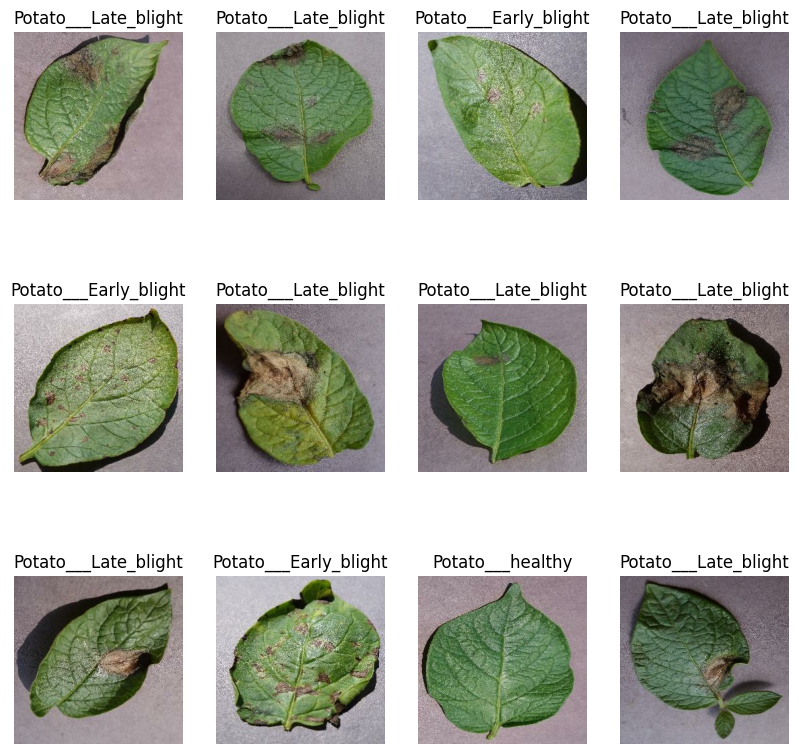

In [14]:
plt.figure(figsize=(10, 10))
for image_batch, label_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i +1)
        plt.imshow(image_batch[i].numpy().astype('uint8'))
        plt.title(class_names[label_batch[i]])
        plt.axis('off')

## 5. Split the dataset (train, test, validate)

In [15]:
train_size = 0.8
len(dataset) * train_size 

54.400000000000006

In [16]:
train_ds = dataset.take(54)

In [22]:
test_ds = dataset.skip(54)

In [23]:
val_size = 0.1
len(dataset) * val_size

6.800000000000001

In [24]:
val_ds = test_ds.take(6)

In [25]:
test_ds = test_ds.skip(6)

In [26]:
len(train_ds), len(test_ds), len(val_ds)

(54, 8, 6)

In [27]:
# function 
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, shuffle=True, shuffle_size=1000):
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(seed=12)
        
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    
    return train_ds, val_ds, test_ds

In [28]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)


## 6. Data Augmentation 

In [30]:
resize_and_rescale = tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    layers.experimental.preprocessing.Rescaling(1./255)
])

In [31]:
data_augmentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip('horizontal_and_vertical'),
    layers.experimental.preprocessing.RandomRotation(0.2)
    
])

In [32]:
# apply data augmentation 
train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
)

## 7. Model architecture

In [45]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 3 

model = models.Sequential([
#     scaling
    resize_and_rescale, 
    
#     convolutional layers
    layers.Conv2D(filters=32, kernel_size=(3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2,2)),
    
    layers.Conv2D(filters=64, kernel_size=(3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
        
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    
#     flattening 1-D
    layers.Flatten(),
    
#     Dense layers
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax')
    
    
])
model.build(input_shape=input_shape)

In [46]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [47]:
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_1 (Sequential)   (32, 256, 256, 3)         0         
                                                                 
 conv2d_18 (Conv2D)          (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d_18 (MaxPooli  (32, 127, 127, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_19 (Conv2D)          (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_19 (MaxPooli  (32, 62, 62, 64)          0         
 ng2D)                                                           
                                                                 
 conv2d_20 (Conv2D)          (32, 60, 60, 64)         

In [48]:
history = model.fit(
    train_ds, 
    batch_size=BATCH_SIZE, 
    validation_data=val_ds,
    verbose=1,
    epochs=EPOCHS
)

Epoch 1/10


2023-11-02 22:02:00.520947: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 264257536 exceeds 10% of free system memory.
2023-11-02 22:02:07.456431: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 66064384 exceeds 10% of free system memory.
2023-11-02 22:02:07.816826: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 128000000 exceeds 10% of free system memory.
2023-11-02 22:02:13.127422: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 62980096 exceeds 10% of free system memory.
2023-11-02 22:02:13.129111: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 128000000 exceeds 10% of free system memory.


54/54 [==============================] - 118s 2s/step - loss: 0.8898 - accuracy: 0.4919 - val_loss: 0.7817 - val_accuracy: 0.5104
Epoch 2/10
54/54 [==============================] - 102s 2s/step - loss: 0.7117 - accuracy: 0.6644 - val_loss: 0.5432 - val_accuracy: 0.7448
Epoch 3/10
54/54 [==============================] - 102s 2s/step - loss: 0.5832 - accuracy: 0.7425 - val_loss: 0.5599 - val_accuracy: 0.7865
Epoch 4/10
54/54 [==============================] - 100s 2s/step - loss: 0.4708 - accuracy: 0.8166 - val_loss: 0.4110 - val_accuracy: 0.8438
Epoch 5/10
54/54 [==============================] - 101s 2s/step - loss: 0.4420 - accuracy: 0.7986 - val_loss: 0.4216 - val_accuracy: 0.8073
Epoch 6/10
54/54 [==============================] - 102s 2s/step - loss: 0.3686 - accuracy: 0.8530 - val_loss: 0.3115 - val_accuracy: 0.8698
Epoch 7/10
54/54 [==============================] - 101s 2s/step - loss: 0.2641 - accuracy: 0.9051 - val_loss: 0.2141 - val_accuracy: 0.9167
Epoch 8/10
54/54 [======

In [49]:
scores = model.evaluate(test_ds)

8/8 [==============================] - 4s 473ms/step - loss: 0.1397 - accuracy: 0.9310


## 8. Evaluating the model 

In [50]:
history.params

{'verbose': 1, 'epochs': 10, 'steps': 54}

In [51]:
54*32

1728

In [52]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [53]:
acc =  history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

Text(0.5, 1.0, 'Training and validation loss')

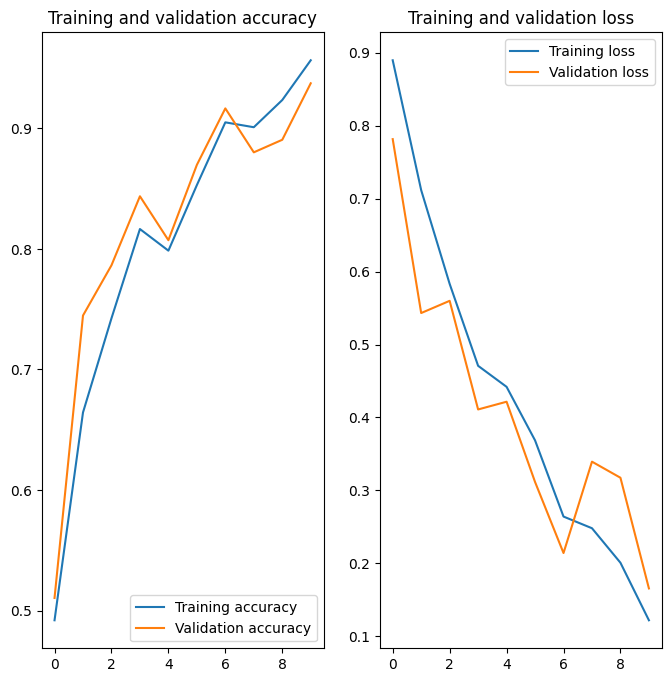

In [54]:
plt.figure(figsize=(8,8))
plt.subplot(1,2,1)
plt.plot(range(EPOCHS), acc, label='Training accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation accuracy')
plt.legend(loc='lower right')
plt.title("Training and validation accuracy")

plt.subplot(1,2,2)
plt.plot(range(EPOCHS), loss, label='Training loss')
plt.plot(range(EPOCHS), val_loss, label='Validation loss')
plt.legend(loc='upper right')
plt.title("Training and validation loss")

## 9. Prediction

Class: Potato___Early_blight
1/1 [==============================] - 1s 646ms/step
Class Potato___Early_blight


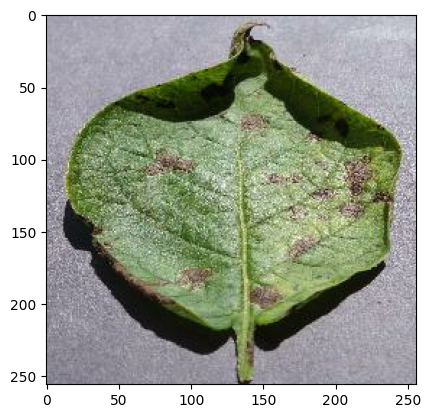

In [58]:
import numpy as np 
for image_batch, label_batch in test_ds.take(1):
    first_image = image_batch[0].numpy().astype('uint8')
    first_label = label_batch[0].numpy()
    plt.imshow(first_image)
    print(f"Class: {class_names[first_label]}")
    
    batch_prediction = model.predict(image_batch)
    print(f"Class {class_names[np.argmax(batch_prediction[0])]}")